# Basline blur classifier model

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import io
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


In [2]:
# ResNet input size
input_size = (224,224)

# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.4853, 0.4290, 0.3761], [0.1348, 0.1184, 0.1311])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.4275, 0.4184, 0.4037], [0.1419, 0.1179, 0.1273])
    ]),
}


## Dataset

In [3]:
class BlurDataset(Dataset):

    def __init__(self, root_dir, imgs_list, transform=None):

        self.root_dir = root_dir
        self.imgs_list = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Blur kaggle dataset case
        if type(self.imgs_list[idx]) == str:
            img_name = self.imgs_list[idx]
            img_tag = self.imgs_list[idx].split("/")[-1].split("_")[-1].split(".")[0]
            if img_tag == "S":
                img_label = 0
            else:
                img_label = 1
         # VizWiz dataset case
        else:
            img_name = os.path.join(self.root_dir, self.imgs_list[idx][0])
            img_label = self.imgs_list[idx][1]

        image = Image.open(img_name)

        if self.transform:
            sample = self.transform(image)

        return sample, img_label

Load dataset

In [4]:
with open('../data/mixed_vwbk_dataset.json', encoding='UTF-8') as m_json_file:
    data = json.load(m_json_file)
    m_train_data = data["train"]
    m_val_data = data["val"]

In [5]:
batch_size = 64

train_dataset = BlurDataset('/media/arnau/PEN/TFG/train/', m_train_data, data_transforms["train"])
val_dataset = BlurDataset('/media/arnau/PEN/TFG/val/', m_val_data, data_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

dataloaders_dict = {"train": train_loader, "val": val_loader}

## Training

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, save_path):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.cpu().detach().numpy())

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    
    torch.save(model.state_dict(), save_path)
    
    return model, acc_history, losses

In [7]:
def initialize_model(num_classes):
    # vgg16
    #model = models.vgg16(pretrained=True)
    model = models.convnext_tiny(pretrained=True)
    
    model.fc = nn.Linear(512,num_classes)# YOUR CODE HERE!
    
    input_size = 224
        
    return model, input_size


# Number of classes in the dataset
num_classes = 2

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)



/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [8]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 4

lr = 6.75027e-05
wd = 8.67514e-09
optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

save_path = '../outputs/best.pth'

if not os.path.exists(save_path):
    # Train and evaluate
    model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, 
                                      num_epochs=num_epochs, save_path=save_path)

Epoch 0/3
----------
train Loss: 2.2835 Acc: 0.5732
val Loss: 0.3719 Acc: 0.8286

Epoch 1/3
----------
train Loss: 0.2811 Acc: 0.8875
val Loss: 0.3212 Acc: 0.8571

Epoch 2/3
----------
train Loss: 0.1874 Acc: 0.9226
val Loss: 0.3131 Acc: 0.8714

Epoch 3/3
----------
train Loss: 0.1352 Acc: 0.9512
val Loss: 0.3371 Acc: 0.8524

Training complete in 2m 53s
Best val Acc: 0.871429


## Results

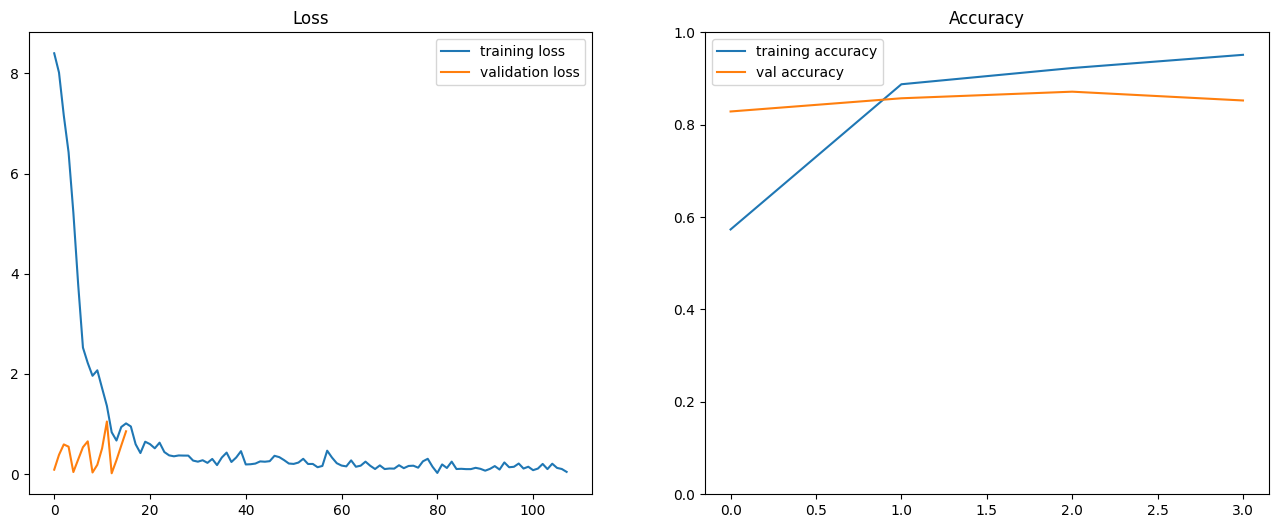

In [13]:
if losses:
    # plot the losses and accuracies
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title("Loss")
    ax1.plot(losses["train"], label="training loss")
    ax1.plot(losses["val"], label="validation loss")
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.plot([x.cpu().numpy() for x in hist["train"]],label="training accuracy")
    ax2.plot([x.cpu().numpy() for x in hist["val"]],label="val accuracy")
    ax2.set_ylim([0, 1])
    ax2.legend()

    plt.show()   

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, loss_fn, test_loader, device):
    
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_true += targets.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total
    test_f1 = f1_score(y_true, y_pred, average='macro')
    test_precision = precision_score(y_true, y_pred, average='macro')
    test_recall = recall_score(y_true, y_pred, average='macro')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test Precision: {test_precision * 100:.2f}%")
    print(f"Test Recall: {test_recall * 100:.2f}%")
    print(f"Test F1 Score: {test_f1 * 100:.2f}%")


In [18]:
test_dataset = BlurDataset('/media/arnau/PEN/TFG/val/', data["test"], data_transforms["val"])
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

model.load_state_dict(torch.load(save_path))

evaluate(model, criterion, test_loader, device)

Test Loss: 0.4793
Test Accuracy: 83.33%
Test Precision: 83.58%
Test Recall: 83.33%
Test F1 Score: 83.30%


## Hyperparemeter tunning

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize
from optuna import Trial, samplers
from optuna.pruners import SuccessiveHalvingPruner


# Define the objective function to optimize
def objective(trial):
    # Define the hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-8)
    batch_size = trial.suggest_categorical("batch_size", [64])
    
    # Define the ConvNetXt model with the hyperparameters
    model = models.convnext_tiny(pretrained=True).to(device)
    
    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Train the model
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.cpu().detach().numpy())

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            acc_history[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)
    
    return losses["val"][-1]


sampler = samplers.TPESampler()
pruner = SuccessiveHalvingPruner()

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=42), pruner=pruner)
study.optimize(objective, n_trials=100, timeout=900)
print('Best trial:', study.best_trial.params)

# get the best trial's parameters and objective value
best_trial = study.best_trial
best_params = best_trial.params
best_value = best_trial.value

# write the best parameters and objective value to a text file
with open("../outputs/best_params.txt", "w") as f:
    f.write(f"Best Parameters: {best_params}\n")
    f.write(f"Best Objective Value: {best_value}\n")